In [78]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime

In [79]:
import numpy as np
import pandas as pd

In [80]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [81]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [82]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [83]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [84]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
inspector=inspect(engine)
columns=inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [86]:
engine.execute('select * from measurement limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [87]:
inspector=inspect(engine)
columns=inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [88]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [90]:
#Calculate the latest dates in the dataset

first_date=session.query(Measurement.date).order_by(Measurement.date).first()
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
                
#Convert to date format for comparison purposes
# Calculate the date 1 year ago from the last data point in the database

query=datetime.strptime(latest_date,"%Y-%m-%d")-dt.timedelta(days=366)
end_date=datetime.strptime(latest_date, "%Y-%m-%d")

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

prcp_results=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>=query).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df=pd.DataFrame(prcp_results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
prcp_df.set_index('Date', inplace=True)
prcp_df.head()



,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


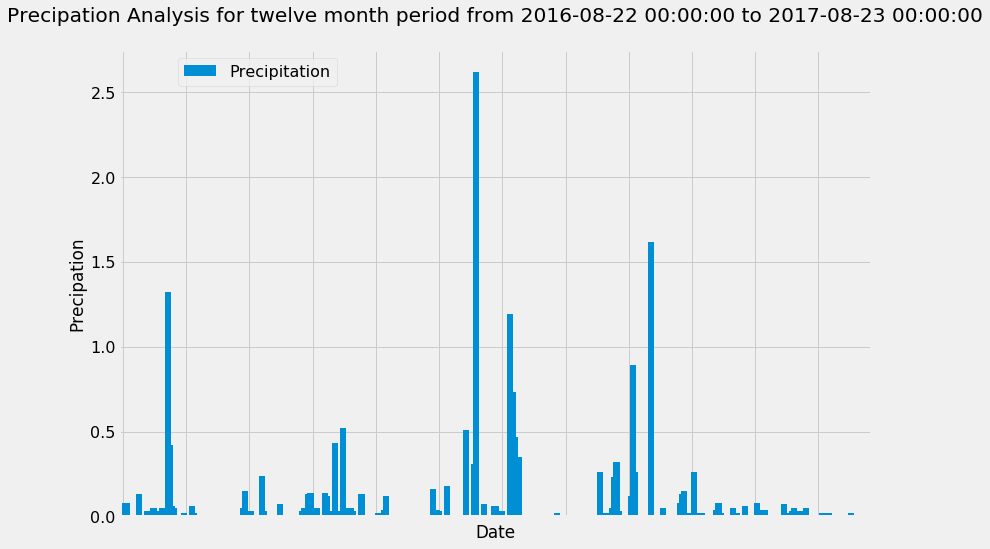

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data

ax=prcp_df.plot(kind='bar', width=3, figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Precipation")
plt.title(f"Precipation Analysis for twelve month period from {query} to {end_date}\n")
plt.locator_params(axis='x', nbins=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.show()

![precipitation](Images/precipitation.png)

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,Precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


![describe](Images/describe.png)

In [93]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temp_stats=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station ==active_stations[0][0]).all()
temp_stats

[(54.0, 85.0, 71.66378066378067)]

In [96]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_results=session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date>=query).\
    filter(Measurement.station==active_stations[0][0]).\
    order_by(Measurement.date).all()

temp_df=pd.DataFrame(temp_results)

temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


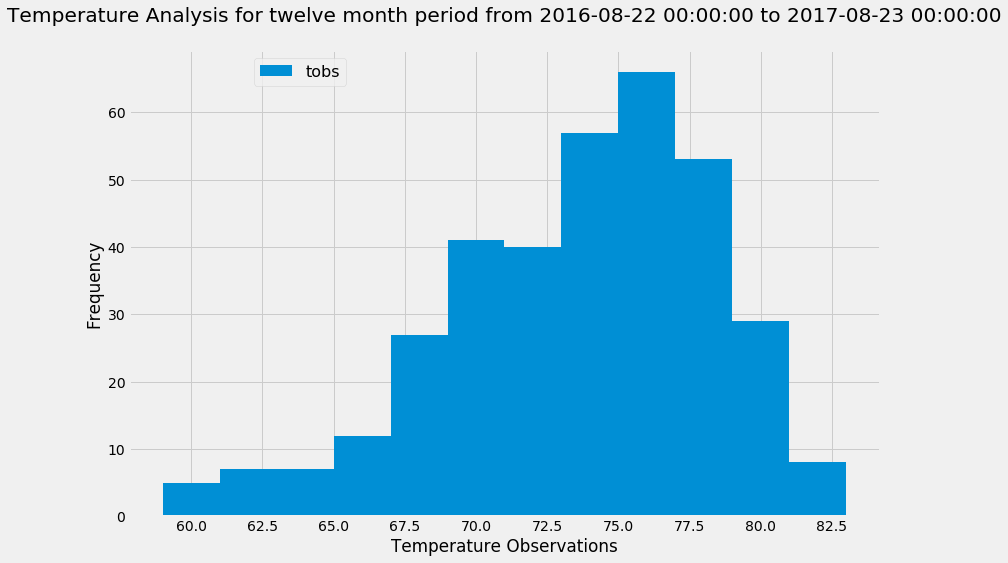

In [97]:
temp_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.xlabel("Temperature Observations")
plt.ylabel("Frequency")
plt.title(f"Temperature Analysis for twelve month period from {query} to {end_date}\n")
plt.locator_params(axis='x', nbins=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.show()

![precipitation](Images/station-histogram.png)

In [98]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [99]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Converting to date to get one year ago and then reconverting to string to use calculate temp function

trip_dates=['2014-12-11', '2014-12-19']
trip_date_start=datetime.strptime(trip_dates[0],"%Y-%m-%d")
year_ago_start=trip_date_start-dt.timedelta(days=365)
year_ago_start_string=datetime.strftime(year_ago_start,"%Y-%m-%d")


trip_date_end=datetime.strptime(trip_dates[1],"%Y-%m-%d")
year_ago_end=trip_date_end-dt.timedelta(days=365)
year_ago_end_string=datetime.strftime(year_ago_end,"%Y-%m-%d")

temp_output=calc_temps(year_ago_start_string, year_ago_end_string)

print(f'The temperature forecast for your vacation period {trip_dates[0]} to {trip_dates[1]} is based on ')
print(f'temperatures from a year ago for the period {year_ago_start_string} to {year_ago_end_string}')                                                                        
print('They are as follows:\n')
print(f'Min Temperature (F):{temp_output[0][0]}')
print(f'Average Temperature (F):{temp_output[0][1]}')
print(f'Max Temperature (F): {temp_output[0][2]}')                                                                              
                                                                              

The temperature forecast for your vacation period 2014-12-11 to 2014-12-19 is based on 
temperatures from a year ago for the period 2013-12-11 to 2013-12-19
They are as follows:

Min Temperature (F):63.0
Average Temperature (F):70.52112676056338
Max Temperature (F): 78.0


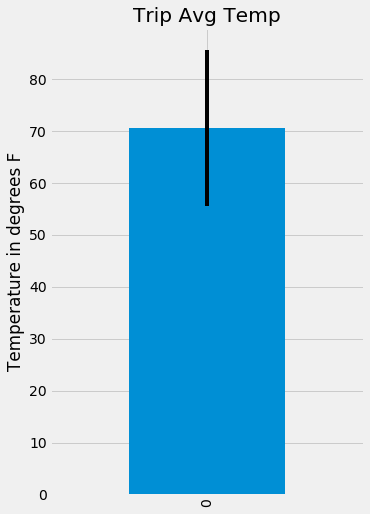

In [100]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

vacation_df=pd.DataFrame(temp_output, columns=['Min Temp', 'Avg Temp', 'Max Temp'])

vacation_df['Avg Temp'].plot(kind='bar', yerr=vacation_df['Max Temp']-vacation_df['Min Temp'], figsize=(5,8))
plt.title('Trip Avg Temp')
plt.ylabel('Temperature in degrees F')
plt.show()



In [101]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

measurement_query = session.query(Measurement.station, func.sum(Measurement.prcp)).\
            filter(Measurement.date>=year_ago_start).filter(Measurement.date<=year_ago_end).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
        
        
  

station_query=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).order_by(Station.station).all()


measurement_df=pd.DataFrame(measurement_query, columns=['Station', 'Total Precipitation for Period'])
station_df=pd.DataFrame(station_query, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

joined_df=measurement_df.merge(station_df, left_on=measurement_df['Station'], right_on=station_df['Station'])
joined_df=joined_df.drop(columns=['Station_x', "key_0", 'Station_y'])

joined_df
              

,Total Precipitation for Period,Name,Latitude,Longitude,Elevation
0,4.19,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,2.99,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,2.55,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
3,2.34,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,1.37,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,1.30,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.61,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,0.02,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,NaN,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


## Optional Challenge Assignment

In [102]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [103]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start=trip_date_start
end=trip_date_end

# Use the start and end date to create a range of dates

date_list = [start + dt.timedelta(days=x) for x in range(9)]

# Stip off the year and save a list of %m-%d strings

month_day_list=[datetime.strftime(date,"%m-%d") for date in date_list]


# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for list_item in month_day_list:
    daily_normal=daily_normals(list_item)
    normals.append(daily_normal)


In [104]:
dates=[]
for item in date_list:
    day=datetime.strftime(item, "%Y-%m-%d")
    dates.append(day)
dates

['2014-12-11',
 '2014-12-12',
 '2014-12-13',
 '2014-12-14',
 '2014-12-15',
 '2014-12-16',
 '2014-12-17',
 '2014-12-18',
 '2014-12-19']

In [105]:
normals

[[(64.0, 72.38775510204081, 78.0)],
 [(64.0, 70.88235294117646, 79.0)],
 [(65.0, 70.9423076923077, 80.0)],
 [(65.0, 71.18, 78.0)],
 [(62.0, 71.34, 79.0)],
 [(60.0, 69.62264150943396, 82.0)],
 [(63.0, 70.64, 77.0)],
 [(63.0, 71.28, 77.0)],
 [(67.0, 72.0, 78.0)]]

In [106]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
min_temp_list=[]
avg_temp_list=[]
max_temp_list=[]
i=0
for x in normals:
    min_temp=normals[i][0][0]
    min_temp_list.append(min_temp)
    i+=1
i=0  
for x in normals:
    avg_temp=normals[i][0][1]
    avg_temp_list.append(avg_temp)
    i+=1
i=0

for x in normals:
    max_temp=normals[i][0][2]
    max_temp_list.append(max_temp)
    i+=1
final_normal_df=pd.DataFrame({'Min Temp':min_temp_list, 'Avg Temp':avg_temp_list, 'Max Temp':max_temp_list,'Trip Dates':dates},index=pd.date_range(start='2014-12-11', end='2014-12-19',freq='D'))

final_normal_df

,Min Temp,Avg Temp,Max Temp,Trip Dates
2014-12-11,64.0,72.387755,78.0,2014-12-11
2014-12-12,64.0,70.882353,79.0,2014-12-12
2014-12-13,65.0,70.942308,80.0,2014-12-13
2014-12-14,65.0,71.180000,78.0,2014-12-14
2014-12-15,62.0,71.340000,79.0,2014-12-15
2014-12-16,60.0,69.622642,82.0,2014-12-16
2014-12-17,63.0,70.640000,77.0,2014-12-17
2014-12-18,63.0,71.280000,77.0,2014-12-18
2014-12-19,67.0,72.000000,78.0,2014-12-19


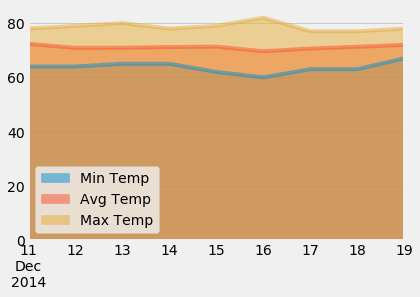

In [107]:
# Plot the daily normals as an area plot with `stacked=False`

ax=final_normal_df.plot.area(stacked=False)